In [1]:
from Main import run_experiment
from Parser import parse_dataset, split_dataset
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

/home/ubuntu/bsc/BootDet/DeepLog-master/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'Windows'
data_seed = 42

# Linux params
# st = 0.4
# depth = 5
# window = 20
# hidden_size = 128
# batch_size = 32
# lr = 0.0001
# top_k = 5

# Windows params
st = 0.4
depth = 5
window = 30
hidden_size = 256
batch_size = 32
lr = 0.001
top_k = 5

parse_dataset(dataset_name, st, depth)
split_dataset(dataset_name, data_seed)

top1_acc, top1_te, topk_acc, topk_te, train_losses, val_losses = run_experiment(
        dataset_name=dataset_name,
        hpo=False,
        window=window,
        hidden_size=hidden_size,
        batch_size=batch_size,
        lr=lr,
        top_k=top_k
    )

print(f"Top-1 Accuracy: {top1_acc:.4f}, Top-{top_k} Accuracy: {topk_acc:.4f}")

Parsing file: /home/ubuntu/bsc/BootDet/DeepLog-master/Data/Windows/Windows.log
Total lines:  19617
Processed 5.1% of log lines.
Processed 10.2% of log lines.
Processed 15.3% of log lines.
Processed 20.4% of log lines.
Processed 25.5% of log lines.
Processed 30.6% of log lines.
Processed 35.7% of log lines.
Processed 40.8% of log lines.
Processed 45.9% of log lines.
Processed 51.0% of log lines.
Processed 56.1% of log lines.
Processed 61.2% of log lines.
Processed 66.3% of log lines.
Processed 71.4% of log lines.
Processed 76.5% of log lines.
Processed 81.6% of log lines.
Processed 86.7% of log lines.
Processed 91.8% of log lines.
Processed 96.9% of log lines.
Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:09.167758]
Train IDs: [  6 136 123 168  86  57  96  36 190  43  66 105 160  79  77  30 137  61
  52 166  39  32 174  13 110  42 133 101  27 129 187  99   3  47 138  91
 146  37 186  23 127 148  34  12 125 155   7  28 162   5  33 144 141  98
 140  11  63 182 142   1 175

/home/ubuntu/bsc/BootDet/DeepLog-master/Parser.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=["label"], inplace=True)


Early stopping triggered.
[Epoch 1/1] average loss = 0.0000 ######################################## (100.00%) runtime 0:00:12.7
Top-1 Accuracy: 0.7488, Top-5 Accuracy: 0.9719


In [3]:
data_path = f"./Data/{dataset_name}/"

is_anomaly_event = (~topk_te).to(torch.int)
test_df = pd.read_csv(f"{data_path}/Temp/{dataset_name}_deeplog_test.csv")
assert len(test_df) == len(is_anomaly_event)

test_df["is_anomaly_event"] = is_anomaly_event.cpu().numpy()

templates = pd.read_csv(f"{data_path}/{dataset_name}.log_templates.csv")
ground_df = pd.read_csv(f"{data_path}/{dataset_name}.log_structured.csv")

component_map = (
    ground_df[["EventId", "Component"]]
    .drop_duplicates("EventId")
    .set_index("EventId")["Component"]
)

top_events = (
    test_df.loc[test_df["is_anomaly_event"].eq(1), "event"]
    .value_counts()
    .head(20)
    .rename("Anomaly Count")
    .reset_index()
    .rename(columns={"event": "EventId"})
)

top_events = (
    top_events
    .merge(
        templates[["EventId", "EventTemplate", "Occurrences"]],
        on="EventId",
        how="left",
    )
)

top_events["Component"] = top_events["EventId"].map(component_map)
top_events



,EventId,Anomaly Count,EventTemplate,Occurrences,Component
0,c1405060,28,The system uptime is<*> seconds.,210,EventLog
1,6787e2df,27,License Activation (slui.exe) failed with the ...,414,Microsoft-Windows-Security-SPP
2,e8cf8511,24,The operating system started at system time <*>,210,Microsoft-Windows-Kernel-General
3,9cbd5165,23,The security account manager is now logging pe...,210,Microsoft-Windows-Directory-Services-SAM
4,ad0f657b,20,Credential Guard auto enablement status. Hardw...,210,LsaSrv
5,a521f79f,18,Pre-attestation health check detailed informat...,202,Microsoft-Windows-TPM-WMI
6,80ab4561,18,DHCPv4 client registered for shutdown notifica...,210,Microsoft-Windows-Dhcp-Client
7,9173bce8,18,Remote calls to the SAM database are being res...,210,Microsoft-Windows-Directory-Services-SAM
8,30e84e4c,17,The Event log service was started.,210,EventLog
9,5791bf67,16,The domain is configured with the following mi...,210,Microsoft-Windows-Directory-Services-SAM


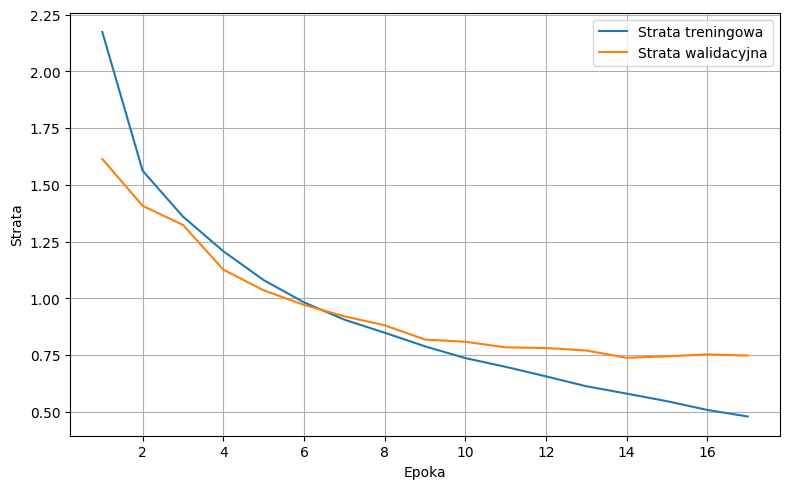

In [4]:
epochs = range(1, len(train_losses) + 1)
t_loss = train_losses
v_loss = val_losses

plt.figure(figsize=(8, 5))
plt.plot(epochs, t_loss, label="Strata treningowa")
plt.plot(epochs, v_loss, label="Strata walidacyjna")
plt.xlabel("Epoka")
plt.ylabel("Strata")
# plt.title("Przebieg uczenia DeepLog na zbiorze Linux")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()